# ISAAC Athletics Analytics - LASSO Logistic Regression Jupyter Notebook

### This Jupyter Notebook contains the Python script to create a LASSO Logistic Regression Model to identify alternative potential predictors other than mRSI.

### 1. Importing libraries

In [5]:
import os
import os.path
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
sns.set()
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

### 2. Importing data

In [6]:
# Define the directory and file path for the dataset
datadir = "data/tidy_data"
data = os.path.join(datadir, "new_jump_data.csv")

# Load the dataset into a DataFrame
df_jump_new = pd.read_csv(data)

# Create a binary variable 'injury_log' to indicate injury occurrence:
# 1 for rows where 'injury_type' is not NaN (indicating an injury), and 0 otherwise
df_jump_new["injury_log"] = df_jump_new["injury_type"].notna().astype(int)

# Select relevant columns for logistic regression analysis
jump_logistic = df_jump_new[[
    'TestId', 'Peak Braking Force', 'Avg. Braking Force', 'Braking Net Impulse',
    'Peak Propulsive Force', 'Avg. Propulsive Force', 'Propulsive Net Impulse',
    'Avg. Braking Velocity', 'Peak Braking Velocity', 'Avg. Propulsive Velocity',
    'Takeoff Velocity', 'Avg. Braking Power', 'Peak Braking Power', 'Avg. Propulsive Power',
    'Peak Propulsive Power', 'L|R Peak Braking Force', 'L|R Peak Propulsive Force',
    'L|R Braking Impulse Index', 'L|R Propulsive Impulse Index', 'mRSI', 'injury_log'
]]

# Set 'TestId' as the index for easier data manipulation and identification of rows
jump_logistic.set_index("TestId", inplace=True)

# Handle missing values by dropping rows with NaN values in any column
jump_logistic = jump_logistic.dropna()

### 3. Running the LASSO Logistic Regression Model

c:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Coefficients for the predictors:
[[-0.93602017  0.31728102  0.18399703 -0.20425136 -0.03059892 -0.67944234
  -0.74028137  1.51799569  0.16908342 -0.4350009  -1.06683805 -0.08003768
  -0.69669661  1.437489    0.21772828  0.21589468 -0.44522351 -0.22799291
   0.24660596]]


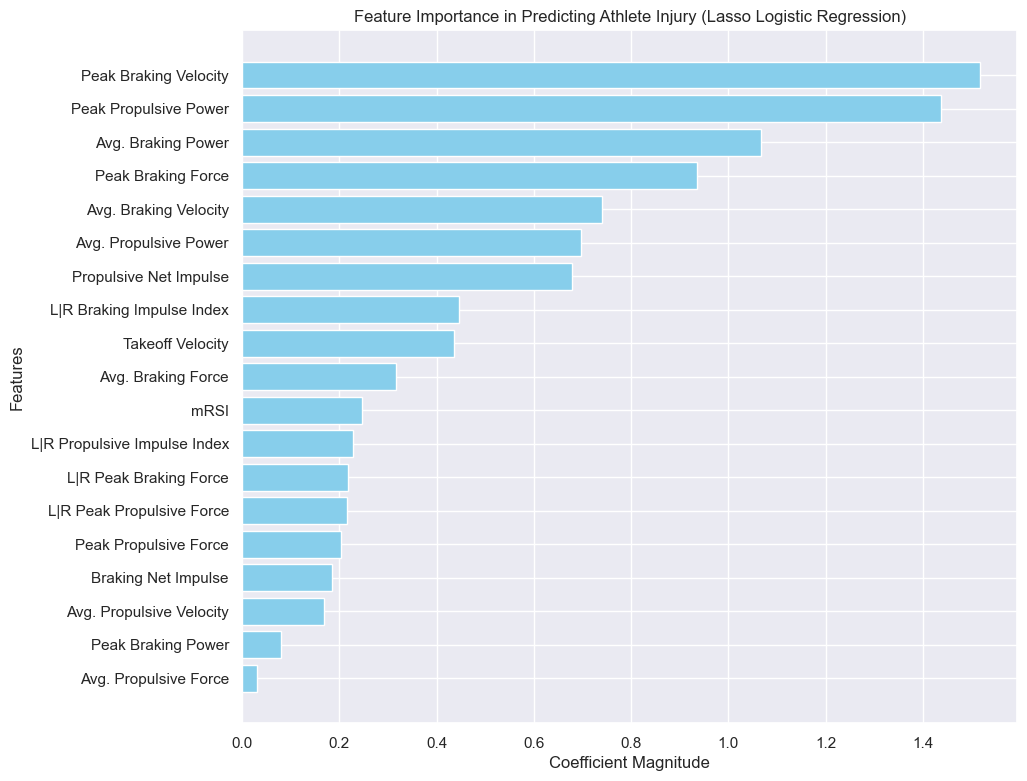

In [8]:
# Separate the features (X) and target variable (y)
# 'injury_log' is the target variable, and the rest are predictors
X = jump_logistic.drop(columns=['injury_log'])
y = jump_logistic[['injury_log']]

# Handle missing values in the feature set by imputing with the mean
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy='mean')
X = imputer.fit_transform(X)

# Set a random seed for reproducibility in the results
import numpy as np
np.random.seed(123)

# Standardize the features to ensure they are on the same scale
# Standardization is critical for models like Lasso that are sensitive to feature scaling
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Initialize and fit the Lasso Logistic Regression model
# Lasso (L1 penalty) helps select the most important predictors by shrinking less important ones to zero
from sklearn.linear_model import LogisticRegression
lasso_model = LogisticRegression(penalty='l1', solver='saga', max_iter=10000)
lasso_model.fit(X, y)

# Extract the coefficients of the fitted model to understand feature importance
coef = lasso_model.coef_

# Print the raw coefficients for debugging purposes
print("Coefficients for the predictors:")
print(coef)

# Retrieve the feature names from the original DataFrame (as X was transformed)
feature_names = jump_logistic.drop(columns=['injury_log']).columns

# Compute the absolute values of coefficients to analyze their magnitude
coefficients = np.abs(lasso_model.coef_[0])

# Sort coefficients and corresponding feature names in descending order of magnitude
sorted_indices = np.argsort(coefficients)[::-1]
sorted_coefficients = coefficients[sorted_indices]
sorted_feature_names = feature_names[sorted_indices]

# Visualize the sorted coefficients in a horizontal bar plot
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 9))
plt.barh(sorted_feature_names, sorted_coefficients, color="skyblue")
plt.xlabel("Coefficient Magnitude")
plt.ylabel("Features")
plt.title("Feature Importance in Predicting Athlete Injury (Lasso Logistic Regression)")
plt.gca().invert_yaxis()  # Invert y-axis for better readability of the bar plot
plt.show()
